# https://www.kaggle.com/competitions/titanic
Построение моделей прогнозирования категории пассажиров Титаника (выживший/погибший)

In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

plt.figure(figsize=(9,7))

<Figure size 900x700 with 0 Axes>

<Figure size 900x700 with 0 Axes>

In [2]:
titanic_df = pd.read_csv('train.csv')
X_real = pd.read_csv('test.csv')
Y_real = pd.read_csv('gender_submission.csv')
titanic_df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


## 1. Предобработка данных и рабочие гипотезы

Гипотезы:
Вероятность спастись зависит от:
1. Возраста (Age);
2. Пола (Sex);
3. Класса каюты (Pclass);
4. Кол-ва родственников первой степени (Parch);
5. Кол-ва родственников второй степени (SibSp);
6. Номера каюты (Cabin);
7. Цены билета (Fare);
8. Места (порт) посадки на борт (Embarked).



In [3]:
titanic_df.Survived.mean()

0.3838383838383838

Доля выживших составляет 38 % , классы умеренно сбалансированы. Среди признаков есть категориальные переменные. Также необходимо проверить корреляцию признаков.


### Возраст (Age):

In [4]:
titanic_df.Age.isna().mean()

0.19865319865319866

В колонке Age пропущено 20 % значений. Заменим их на средние знаечния по колонке. Разобъем пассажиров по группам для наглядности. Сделаем сводную таблицу и гистограмму. 

<AxesSubplot:xlabel='%'>

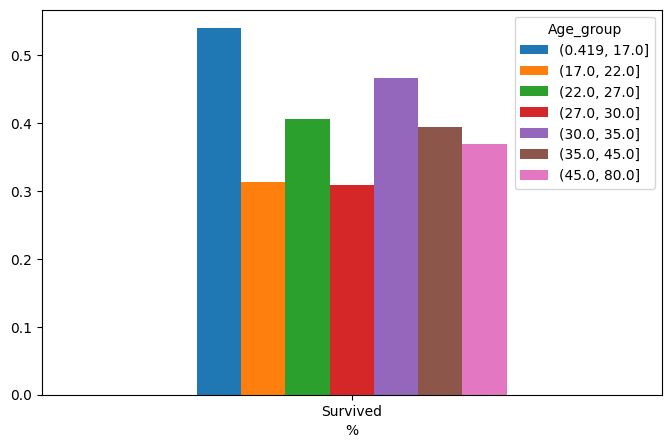

In [5]:
titanic_df.fillna({'Age': titanic_df.Age.mean().round(0)}, inplace=True)
titanic_df['Age_group'] = pd.qcut(titanic_df.Age, 8, duplicates='drop')
titanic_df.pivot_table(values='Survived', columns='Age_group', aggfunc="mean", 
                dropna=False, fill_value=0).plot(kind='bar', xlabel='%', figsize=(8,5), rot=360)

Из диаграммы видно, что имеется некоторая зависимость между процентом выживших в разных возратсных группах. Особенно между группой пассажиров до 16 лет включительно и другими.

### Пол (Sex):

In [6]:
titanic_df.Sex.isna().mean()

0.0

<AxesSubplot:xlabel='%'>

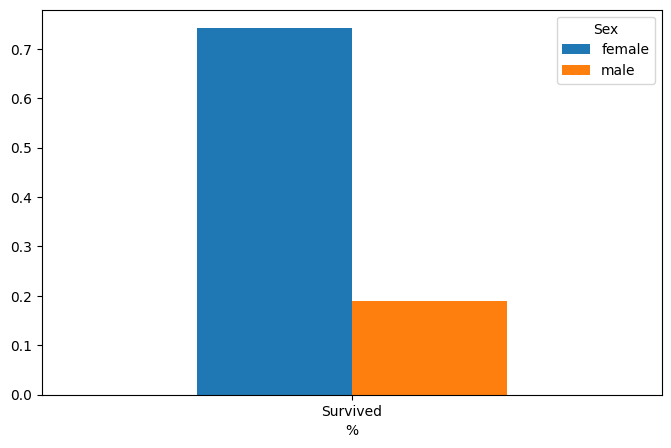

In [7]:
titanic_df.pivot_table(values='Survived', columns='Sex', aggfunc="mean", 
                dropna=False, fill_value=0).plot(kind='bar', xlabel='%', figsize=(8,5), rot=360)

На гистограмме видна отчетливая зависимость между шансом спастись и полом пассажира.

Закодируем категориальные переменные male/female с помощью LabelEncoder()

In [8]:
le = LabelEncoder()

In [9]:
le.fit(titanic_df.Sex)

LabelEncoder()

In [10]:
le.classes_

array(['female', 'male'], dtype=object)

In [11]:
titanic_df['Sex'] = le.transform(titanic_df.Sex)

In [12]:
titanic_df.Sex

0      1
1      0
2      0
3      0
4      1
      ..
886    1
887    0
888    0
889    1
890    1
Name: Sex, Length: 891, dtype: int32

### Класс каюты (Pclass):

In [13]:
titanic_df.Pclass.isna().mean()

0.0

In [14]:
titanic_df.Pclass.value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

<AxesSubplot:xlabel='%'>

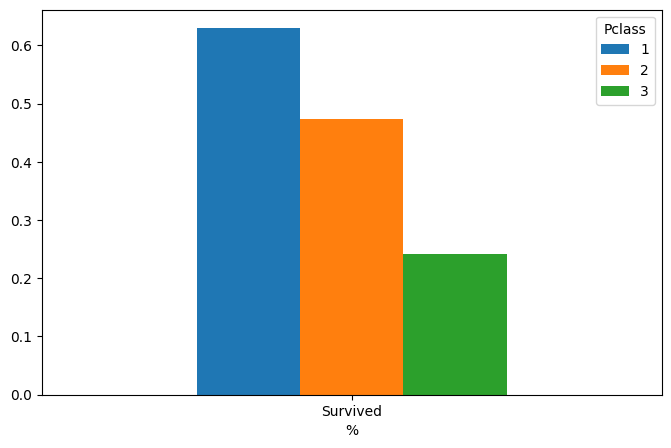

In [15]:
titanic_df.pivot_table(values='Survived', columns='Pclass', aggfunc="mean", 
                       dropna=False, fill_value=0).plot(kind='bar', figsize=(8,5), xlabel='%', rot=360)

Имеется троекратная разница между 1 и 3 классом кают и процентом выживших в классе.

### Номер каюты (Cabin):

In [16]:
titanic_df.Cabin.isna().mean()

0.7710437710437711

Данный признак, возможно, следует исключить из модел ввиду большого процент неизвестных значений.

Пометим неизвестные значения как 'Unknown'. А также сгруппируем каюты по секциям, в которых они находились - первая буква в названии каюты.

<AxesSubplot:xlabel='%'>

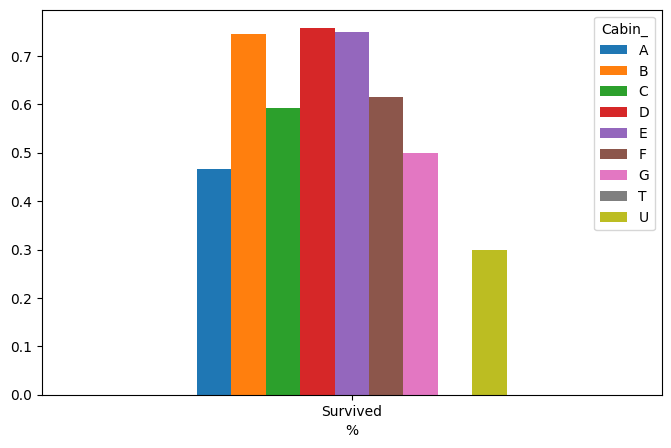

In [17]:
titanic_df = titanic_df.fillna({'Cabin': 'Unknown'})
titanic_df['Cabin_'] = titanic_df.Cabin.map(lambda x: x[0])
titanic_df.pivot_table(values='Survived', columns='Cabin_', aggfunc="mean", 
                dropna=False, fill_value=0).plot(kind='bar', figsize=(8,5), xlabel='%', rot=360)

Секция с каютами является значительным фактором выживания. Однако большинство наблюдений находятся в группе Unknown. Поэтому этот признак следует рассматривать как вторичный или исключить в случае корреляции с другими признаками. Закодируем колонку Cabin_.

In [18]:
dic_cabin_ = {key:value for key, value in zip(titanic_df.Cabin_.unique(), range(len(titanic_df.Cabin_.unique()) ))}
titanic_df.replace({'Cabin_': dic_cabin_}, inplace=True)

In [19]:
titanic_df.Cabin_.value_counts()

0    687
1     59
6     47
4     33
2     32
5     15
7     13
3      4
8      1
Name: Cabin_, dtype: int64

### Кол-во родственников первой степени (Parch)

In [20]:
titanic_df.Parch.isna().mean()

0.0

In [21]:
titanic_df.Parch.value_counts()

0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: Parch, dtype: int64

По данному признаку имеются выбросы. Лишь 15 человек имело более 2 близких родственников. Эти наблюдения можно удалить, или сгруппировать все значения колонки в группы: нет родственников, 1, более 1.

<AxesSubplot:xlabel='%'>

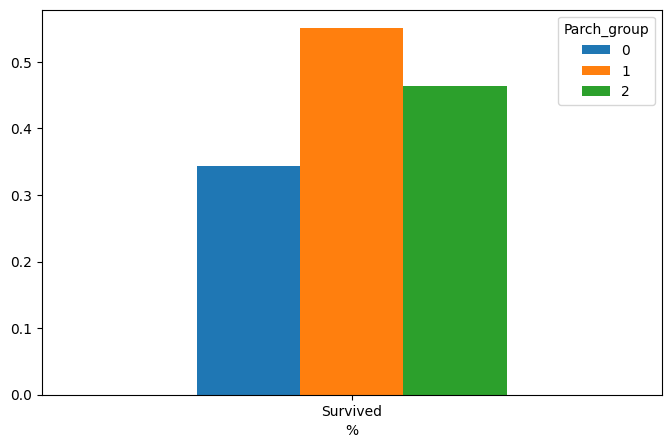

In [22]:
titanic_df.groupby('Parch').agg({'Survived':['count','mean']})
titanic_df['Parch_group'] = titanic_df.Parch.map(lambda x: 1 if x == 1 else (2 if x > 1 else 0))
titanic_df.groupby('Parch_group').agg({'Survived':['count','mean']})
titanic_df.pivot_table(values='Survived', columns='Parch_group', aggfunc="mean", 
                       dropna=False, fill_value=0).plot(kind='bar', xlabel='%', figsize=(8,5), rot=360)

Наибольший шанс выжить имели пассажиры с одним близким родственником.

### Кол-во родственников второй степени (Sibsp)

In [23]:
titanic_df.SibSp.isna().mean()

0.0

In [24]:
titanic_df.SibSp.value_counts()

0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64

По данному признаку также имеются выбросы. Лишь 12 человек имело более 4 близких родственников. Эти наблюдения можно удалить, или сгруппировать все значения колонки в группы: нет родственников, 1, более 1.

<AxesSubplot:xlabel='%'>

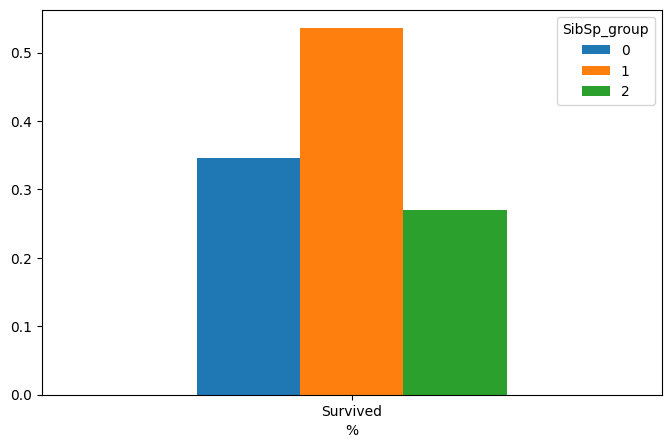

In [25]:
titanic_df.groupby('SibSp').agg({'Survived': ['count','mean']})
titanic_df['SibSp_group'] = titanic_df.SibSp.map(lambda x: 1 if x == 1 else (2 if x > 1 else 0))
titanic_df.pivot_table(values='Survived', columns='SibSp_group', aggfunc="mean", 
                       dropna=False, fill_value=0).plot(kind='bar', xlabel='%', figsize=(8,5), rot=360)

Наибольший шанс выжить имели пассажиры с одним родственником второй степени родства.

### Цена билета (Fare):

In [26]:
titanic_df.Fare.isna().mean()

0.0

In [27]:
titanic_df.Fare.describe()

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

По колонке Fare имеется выброс. При максимальной цене 512 ед. процентиль 75 находится на уровне 31 ед.

In [28]:
titanic_df.Fare.quantile(0.95)

112.07915

Процентиль 95 равен 112 ед. Таким образом, чтобы избежать выброс, можно отобрать наблюдения до порога 112 ед. по колонке Fare, или объединить значения в группы.

<AxesSubplot:xlabel='%'>

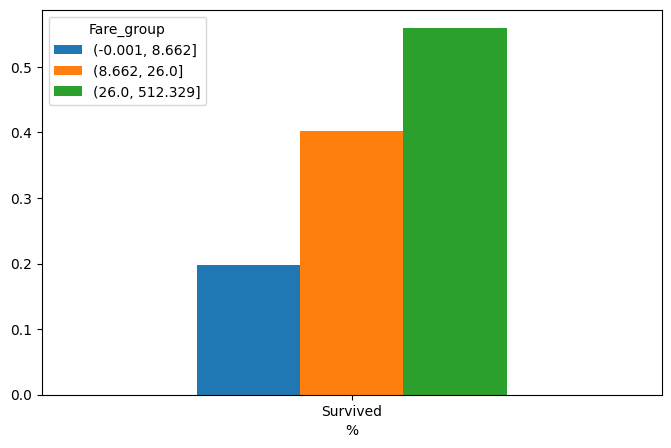

In [29]:
titanic_df['Fare_group'] = pd.qcut(titanic_df.Fare, 3, duplicates='drop')
titanic_df.pivot_table(values='Survived', columns='Fare_group', aggfunc="mean", 
                       dropna=False, fill_value=0).plot(kind='bar', xlabel='%', figsize=(8,5),rot=360)

Чем выше стоимость билета пасажира, тем чаще в среднем он спасался.

Закодируем значения в колонке Fare_group.

In [30]:
titanic_df['Fare_group'] = titanic_df.Fare.map(lambda x: 0 if x < 8.662 else (1 if x <= 26 else 3))

### Место (порт) посадки на борт (Embarked):

In [31]:
titanic_df.Embarked.isna().mean()

0.002244668911335578

In [32]:
titanic_df.Embarked.value_counts(dropna=False)

S      644
C      168
Q       77
NaN      2
Name: Embarked, dtype: int64

Заменим пропущенные значения на самое часто встречающееся - S.

In [33]:
titanic_df.fillna({'Embarked':titanic_df.groupby('Embarked').count()['PassengerId'].idxmax()}, inplace=True)

<AxesSubplot:xlabel='%'>

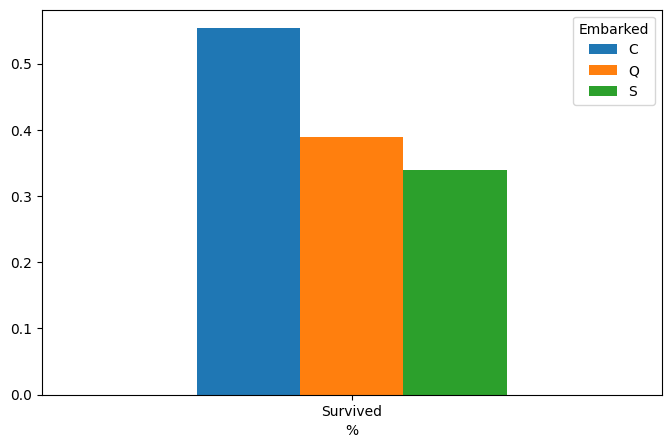

In [34]:
titanic_df.pivot_table(values='Survived', columns='Embarked', 
                       aggfunc="mean", dropna=False, fill_value=0).plot(kind='bar', xlabel='%', figsize=(8,5), rot=360)


Имеется зависимсть между шансом спастись и портом посадки на борт. 


Закодируем категориальные переменные в колонке Embarked.

In [35]:
dic_Embarked = {key:value for key, value in zip(titanic_df.Embarked.unique(), range(len(titanic_df.Embarked.unique()) ))}
titanic_df.replace({'Embarked': dic_Embarked}, inplace=True)

### Проверим корреляцию обработанных данных

In [36]:
titanic_df2 = titanic_df[['Survived', 'Pclass', 'Sex', 'Age', 'SibSp_group', 'Parch_group', 
                          'Fare_group', 'Embarked', 'Cabin_']].copy()

In [37]:
titanic_df2.corr()

,Survived,Pclass,Sex,Age,SibSp_group,Parch_group,Fare_group,Embarked,Cabin_
Survived,1.000000,-0.338481,-0.543351,-0.070657,0.054203,0.121076,0.290990,0.106811,0.270310
Pclass,-0.338481,1.000000,0.131900,-0.329727,-0.000390,-0.010256,-0.726012,0.045702,-0.562800
Sex,-0.543351,0.131900,1.000000,0.084660,-0.177623,-0.253248,-0.200369,-0.116569,-0.114229
Age,-0.070657,-0.329727,0.084660,1.000000,-0.227170,-0.262109,0.114108,0.010407,0.165826
SibSp_group,0.054203,-0.000390,-0.177623,-0.227170,1.000000,0.450499,0.373618,-0.038850,-0.011344
Parch_group,0.121076,-0.010256,-0.253248,-0.262109,0.450499,1.000000,0.385410,-0.083436,0.067265
Fare_group,0.290990,-0.726012,-0.200369,0.114108,0.373618,0.385410,1.000000,-0.050598,0.417791
Embarked,0.106811,0.045702,-0.116569,0.010407,-0.038850,-0.083436,-0.050598,1.000000,0.017250
Cabin_,0.270310,-0.562800,-0.114229,0.165826,-0.011344,0.067265,0.417791,0.017250,1.000000


<AxesSubplot:>

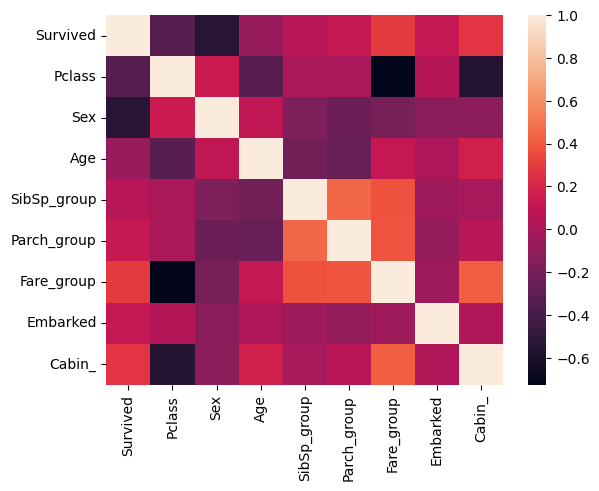

In [38]:
sns.heatmap(titanic_df2.corr())

Корреляционная матрица показывает, что наибольшее влияние на шанс выжить оказывают такие признаки как пол пассажира и класс билета Pclass. Между признаками Pclass и Cabin_,  Pclass и Fare_group имеется значительная корреляция. Удалим Cabin_ и Fare_group из модели.

Создадим итоговый набор данных.

In [39]:
X = titanic_df2[['Pclass', 'Sex', 'Age', 'SibSp_group', 'Parch_group', 'Embarked']].copy()
X.isna().mean()

Pclass         0.0
Sex            0.0
Age            0.0
SibSp_group    0.0
Parch_group    0.0
Embarked       0.0
dtype: float64

In [40]:
Y = titanic_df2.Survived

Создадим наборы переменных для тренировки моделей и для тестирования в соотношении 3 к 1.

In [41]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.25, random_state=5)

Сделаем предобработку данных X_real на которых будем делать прогнозы по построенным моделям.

In [42]:
X_real.isna().mean()

PassengerId    0.000000
Pclass         0.000000
Name           0.000000
Sex            0.000000
Age            0.205742
SibSp          0.000000
Parch          0.000000
Ticket         0.000000
Fare           0.002392
Cabin          0.782297
Embarked       0.000000
dtype: float64

In [43]:
le = LabelEncoder()

In [44]:
le.fit(X_real.Sex)

LabelEncoder()

In [45]:
le.classes_

array(['female', 'male'], dtype=object)

In [46]:
X_real['Sex'] = le.transform(X_real.Sex)

In [47]:
X_real['Parch_group'] = X_real.Parch.map(lambda x: 1 if x == 1 else (2 if x > 1 else 0))

In [48]:
X_real['SibSp_group'] = X_real.SibSp.map(lambda x: 1 if x == 1 else (2 if x > 1 else 0))

In [49]:
X_real.fillna({'Age': X_real.Age.mean().round(0)}, inplace=True)

In [50]:
X_real.fillna({'Embarked':X_real.groupby('Embarked').count()['PassengerId'].idxmax()}, inplace=True)

In [51]:
dic_Embarked_x = {key:value for key, value in zip(X_real.Embarked.unique(), range(len(X_real.Embarked.unique()) ))}
X_real.replace({'Embarked': dic_Embarked_x}, inplace=True)

In [52]:
X_real = X_real[['Pclass', 'Sex', 'Age', 'SibSp_group', 'Parch_group', 'Embarked']]

In [53]:
X_real

,Pclass,Sex,Age,SibSp_group,Parch_group,Embarked
0,3,1,34.5,0,0,0
1,3,0,47.0,1,0,1
2,2,1,62.0,0,0,0
3,3,1,27.0,0,0,1
4,3,0,22.0,1,1,1
...,...,...,...,...,...,...
413,3,1,30.0,0,0,1
414,1,0,39.0,0,0,2
415,3,1,38.5,0,0,1
416,3,1,30.0,0,0,1


##  2. Построение моделей и прогнозирование

### Random Forest

In [54]:
rnd_forest = RandomForestClassifier(random_state=42)

In [55]:
params = {'n_estimators': [50,75], 'max_depth': range(3, 8), 'min_samples_split': range(2,20), 'min_samples_leaf': range(1,10)}

In [56]:
grid_search = GridSearchCV(rnd_forest, params, cv=5)

In [57]:
grid_search.fit(X_train, Y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': range(3, 8),
                         'min_samples_leaf': range(1, 10),
                         'min_samples_split': range(2, 20),
                         'n_estimators': [50, 75]})

In [58]:
grid_search.best_params_

{'max_depth': 5,
 'min_samples_leaf': 1,
 'min_samples_split': 13,
 'n_estimators': 50}

In [59]:
rnd_forest_est = grid_search.best_estimator_

<AxesSubplot:>

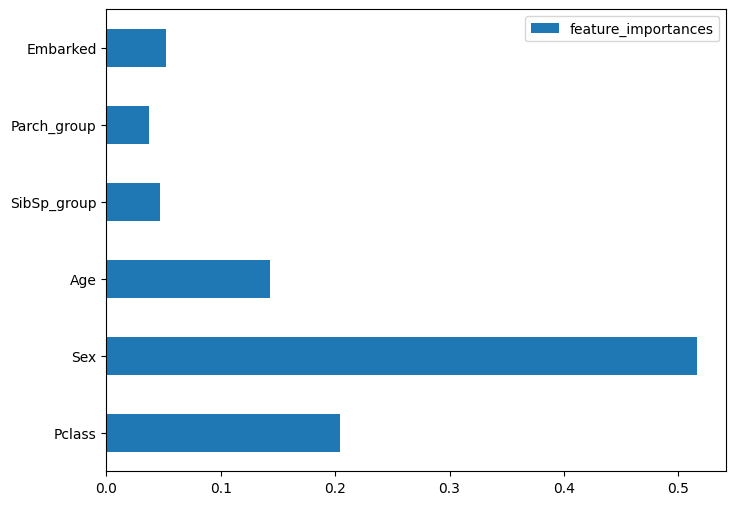

In [60]:
feature_importances = rnd_forest_est.feature_importances_ 
pd.DataFrame({'feature_importances': feature_importances}, index=X_train.columns).plot(kind='barh', figsize=(8, 6))


Наибольший вклад в снижении энтропии в модели Random Forest внесли такие признаки как Пол, класс билета и возраст. 

Сделаем прогноз по тестовым данным и оценим качество модели.

In [61]:
Y_pred = rnd_forest_est.predict(X_test)

In [62]:
rnd_forest_est.score(X_test, Y_test)

0.8385650224215246

Согласно общей точности модели (accuracy = (TP + TN)/(All Cases)) в 8 из 10 случаев она верно классифицирует наблюдение. Для умеренно сбалансированных данных показатель находится на приемлемом урове.

In [63]:
sklearn.metrics.precision_score(Y_test, Y_pred)

0.8615384615384616

Точность модели (TP/(TP+FP)) при определении класса Positive составляет 88%. Т.е. с вероятность 88% пассажир, отмеченный моделью, как выживший, действительно окажется выжившим.

In [64]:
sklearn.metrics.recall_score(Y_test, Y_pred)

0.6746987951807228

Не высокий показатель recall (TP/(TP+FN)) говорит о неполноте охвата моделью положительных наблюдений.

In [65]:
sklearn.metrics.f1_score(Y_test, Y_pred)

0.7567567567567568

### Построим новую модель, оставив наиболее значимые признаки, увеличив диапазон параметров для поиска лучшей модели, а также увеличив число выборок для кроссвалидации

In [66]:
X2 = X[['Age','Sex', 'Pclass']].copy()

In [67]:
Y2 = Y.copy()

In [68]:
X_train2, X_test2, Y_train2, Y_test2 = train_test_split(X2,Y2, test_size=0.25, random_state=7)

In [69]:
rnd_forest2 = RandomForestClassifier(random_state=43)

In [70]:
params2 = {'n_estimators': [50,75,100], 'max_depth': range(3, 12), 'min_samples_split': range(2,10), 
           'min_samples_leaf': range(1,5)}

In [71]:
grid_search2 = GridSearchCV(rnd_forest2, params2, cv=10)

In [72]:
grid_search2.fit(X_train2, Y_train2)

GridSearchCV(cv=10, estimator=RandomForestClassifier(random_state=43),
             param_grid={'max_depth': range(3, 12),
                         'min_samples_leaf': range(1, 5),
                         'min_samples_split': range(2, 10),
                         'n_estimators': [50, 75, 100]})

In [73]:
grid_search2.best_params_


{'max_depth': 5,
 'min_samples_leaf': 1,
 'min_samples_split': 8,
 'n_estimators': 50}

In [74]:
rnd_forest_est2 = grid_search2.best_estimator_

In [75]:
Y_pred2 = rnd_forest_est2.predict(X_test2)

In [76]:
rnd_forest_est2.score(X_test2, Y_test2)

0.757847533632287

In [77]:
sklearn.metrics.precision_score(Y_test2, Y_pred2)

0.7361111111111112

In [78]:
sklearn.metrics.recall_score(Y_test2, Y_pred2)

0.6022727272727273

Уменьшение числа признаков для классификации не улучшило метрики качества модели. Для прогнозирования будем использовать первую модель rnd_forest_est.

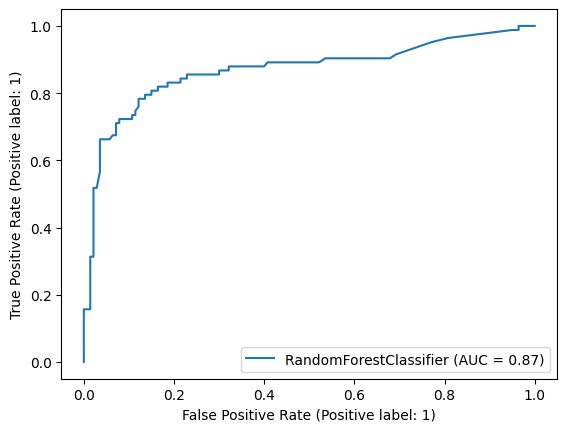

In [79]:
sklearn.metrics.RocCurveDisplay.from_estimator(rnd_forest_est, X_test, Y_test)


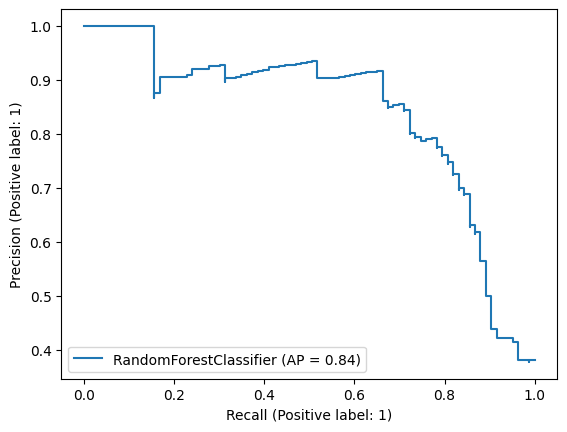

In [80]:
sklearn.metrics.PrecisionRecallDisplay.from_estimator(rnd_forest_est, X_test, Y_test)

По графику видно, что оптимальное соотношение recall и precision находится примерно на отметке 0.8 и 0.75 соответственно. Скорректируем прогнозы по модели, изменяя порог вероятности отнесения к классу Positive. Общая доля выживших составляет 38%. Можно предположить, что оптимальный порог вероятности отнесения к классу выживших находится в пределах 38 - 50%.

In [111]:
y_pred_prob = rnd_forest_est.predict_proba(X_test)
y_pred_mod = np.where(y_pred_prob[:,1] >0.35, 1,0) 

In [112]:
sklearn.metrics.f1_score(Y_test, y_pred_mod)

0.7784431137724551

In [113]:
sklearn.metrics.recall_score(Y_test, y_pred_mod)

0.7831325301204819

In [114]:
sklearn.metrics.precision_score(Y_test, y_pred_mod)

0.7738095238095238

### Применим построенную модель random_forest к реальным данным

In [85]:
result = rnd_forest_est.predict(X_real)

In [115]:
result_prob = rnd_forest_est.predict_proba(X_real)
result_mod = np.where(result_prob[:,1] >0.35, 1,0) 

In [116]:
rnd_forest_est.score(X_real, Y_real.Survived)

0.9114832535885168

В 9 из 10 случаях построенная модель правильно определила класс пассажиров.

In [117]:
sklearn.metrics.precision_score(Y_real.Survived, result_mod)

0.7587939698492462

В 76 % случаях пассажир, отмеченный моделью, как выживший, действительно оказался выжившим. Показатель не достаточно высокий, т.е. модель имеет большое число ложно-положительных срабатываний. 

In [118]:
sklearn.metrics.recall_score(Y_real.Survived, result)

0.8026315789473685

Модель верно выделила 80 из 100 реально выживших пассажиров.

In [119]:
result_mod_df = pd.DataFrame({'PassengerId':Y_real.PassengerId, 'Survived':result_mod}).set_index('PassengerId')

In [120]:
result_mod_df.to_csv('titanic_predict_rnd_forest.csv')